In [ ]:
# import wandb
# !wandb login

In [226]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from scipy.stats import qmc, norm
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid', font_scale=1.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
def black_scholes(S, K, T, r, sigma, option='call'):
    """
    Black-Scholes closed-form formula for European call and put options.
    
    Parameters:
        S (float): underlying asset price
        K (float): option strike price
        T (float): time to maturity in years
        r (float): risk-free interest rate
        sigma (float): volatility of the underlying asset
        option (str): 'call' for call option, 'put' for put option (default is 'call')
    
    Returns:
        float: option price according to the Black-Scholes formula
    """
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

In [6]:
data_description = '''
    msft_calls - list of pandas DataFrames, every item corresponds expiration 
                 expiration date from `expirations`. Each DF contains trading
                 info about call option
    
    msft_puts - same but for put options
    
    expirations - tuple of expirations dates in string format `YYYY-MM-DD`
'''

msft_calls = pd.read_pickle('data/msft_calls.pickle')
msft_puts = pd.read_pickle('data/msft_puts.pickle')
expirations = pd.read_pickle('data/expirations.pickle')

msft_stock_price = 294.3900146484375
day = '2022-03-16'

In [7]:
maturities = [
    (
        datetime.strptime(expiration, '%Y-%m-%d') - 
        (datetime.strptime(day, '%Y-%m-%d') if day else datetime.today())
    ).days / 256 
    for expiration in expirations
]

In [185]:
def real_data_to_format(real_df, real_price, maturity, risk_free_rate):
    df = pd.DataFrame()
    df['S2K'] = real_price / real_df.strike
    df['T'] = maturity
    df['r'] = risk_free_rate
    df['sigma'] = real_df.impliedVolatility
    df['V2K'] = (real_df.bid + real_df.ask) / 2 / real_df.strike
    # df['time_value'] = df['V2K'] - np.maximum(0, df['S2K'] - np.exp(-df['r'] * df['T']))
    # df = df.loc[df.time_value > 1e-7].copy()
    # df['log_time_value'] = np.log(df['time_value'])
    # 0/0
    df = df.loc[(df.V2K > 1e-7) & (df.S2K > 1e-7)].copy()
    df['log_V2K'] = np.log(df['V2K'])
    df['log_S2K'] = np.log(df['S2K'])
    return df

In [36]:
idx = 2 
real_df_concated = pd.concat([
    real_data_to_format(msft_calls[idx], msft_stock_price, maturities[idx], 0.05) for idx in range(len(msft_calls))
])
display(real_df_concated.head())
real_df_concated.info()

,S2K,T,r,sigma,V2K,log_V2K,log_S2K
0,3.679875,0.007812,0.05,8.390630,2.614375,0.961025,1.302879
1,3.463412,0.007812,0.05,7.537110,2.432941,0.889101,1.242254
2,3.271000,0.007812,0.05,7.299806,2.224444,0.799507,1.185096
3,3.098842,0.007812,0.05,6.007815,2.151053,0.765957,1.131029
4,2.943900,0.007812,0.05,6.179690,1.834000,0.606499,1.079735


<class 'pandas.core.frame.DataFrame'>
Index: 978 entries, 0 to 67
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S2K      978 non-null    float64
 1   T        978 non-null    float64
 2   r        978 non-null    float64
 3   sigma    978 non-null    float64
 4   V2K      978 non-null    float64
 5   log_V2K  978 non-null    float64
 6   log_S2K  978 non-null    float64
dtypes: float64(7)
memory usage: 61.1 KB


In [37]:
real_df_concated.describe()

,S2K,T,r,sigma,V2K,log_V2K,log_S2K
count,978.000000,978.000000,9.780000e+02,978.000000,978.000000,978.000000,978.000000
mean,1.143550,0.743857,5.000000e-02,0.566510,0.259377,-3.532163,0.056342
std,0.513673,0.749395,6.595322e-16,1.047488,0.438352,3.002779,0.375321
min,0.566135,0.007812,5.000000e-02,0.000010,0.000019,-10.858999,-0.568923
25%,0.795649,0.113281,5.000000e-02,0.291809,0.004594,-5.383341,-0.228598
50%,0.997932,0.472656,5.000000e-02,0.346030,0.062926,-2.765793,-0.002070
75%,1.308400,1.210938,5.000000e-02,0.497136,0.306436,-1.182748,0.268805
max,3.679875,2.632812,5.000000e-02,14.885255,2.614375,0.961025,1.302879


### Parameters distributions

In [136]:
# for col in real_df_concated.columns:
#     plt.figure(figsize=(6,4))
#     plt.title(col)
#     plt.hist(real_df_concated[col], bins=25)
#     plt.show()

In [39]:
example_param_set = {
    'S' : 0.5,
    'K' : 1,
    'T' : 0.5,
    'r' : 0.05,
    'sigma' : 0.3 
}

black_scholes(**example_param_set)

3.2874437202908e-05

## Parameters sampling

In [40]:
# S2K, T, r, sigma -> V2K
# r may be constant
# n_samples = 1_000_000
# bounds_dict = {
#     'S2K' : (0.25, 4),
#     'T' : (0.01, 2),
#     'r' : (0.01, 0.1),
#     'sigma' : (0.01, 15)
# }
# l_bounds = [i[0] for k,i in bounds_dict.items()]
# r_bounds = [i[1] for k,i in bounds_dict.items()]
# lhc = qmc.LatinHypercube(d=4)
# bs_params = qmc.scale(lhc.random(n=n_samples), l_bounds, r_bounds)
# bs_params.shape

(1000000, 4)

In [188]:
distributions = pd.read_pickle('distributions.pkl')

def sample_distr(distr_info, size):
    distr = distr_info[0]
    params = distr_info[1]
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    if arg:
        return distr.rvs(size=size, *arg, loc=loc, scale=scale)
    else: 
        return distr.rvs(size=size, loc=loc, scale=scale)

In [214]:
n_samples = 500_000
bs_params = np.vstack([
    sample_distr(distributions['S2K'], n_samples), 
    np.random.uniform(0.01, 2, n_samples), # T
    np.random.uniform(0.01, 0.1, n_samples), # r
    sample_distr(distributions['sigma'], n_samples),
]).T
bs_params.shape

(500000, 4)

In [215]:
%%time
prices = np.apply_along_axis(
    func1d=lambda x: black_scholes(x[0], 1, x[1], x[2], x[3]), 
    axis=1,
    arr=bs_params
)
prices.shape

CPU times: user 39.5 s, sys: 3.72 ms, total: 39.5 s
Wall time: 39.5 s


(500000,)

In [216]:
df = pd.DataFrame(data=bs_params, columns=['S2K', 'T', 'r', 'sigma'])
df['V2K'] = prices
display(df.head())
df.info()

,S2K,T,r,sigma,V2K
0,1.385154,0.804165,0.055634,0.616053,0.522333
1,0.782463,0.919889,0.024426,0.712509,0.149564
2,0.785911,0.319909,0.018453,0.378591,0.013004
3,0.930099,1.244816,0.034510,0.240164,0.087293
4,0.583843,0.859095,0.044179,0.483653,0.021988


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   S2K     500000 non-null  float64
 1   T       500000 non-null  float64
 2   r       500000 non-null  float64
 3   sigma   500000 non-null  float64
 4   V2K     500000 non-null  float64
dtypes: float64(5)
memory usage: 19.1 MB


In [217]:
display(df.describe())
display(real_df_concated.describe())

,S2K,T,r,sigma,V2K
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,1.146157,1.007094,0.054970,0.501968,0.374691
std,0.552362,0.574137,0.025979,0.372550,0.496635
min,0.515881,0.010001,0.010000,-0.032763,-0.345139
25%,0.798684,0.510366,0.032472,0.251140,0.068065
50%,0.992020,1.006870,0.054964,0.408612,0.218741
75%,1.309433,1.504852,0.077447,0.644993,0.491198
max,24.289809,1.999993,0.100000,8.597162,23.328940


,S2K,T,r,sigma,V2K,log_V2K,log_S2K
count,978.000000,978.000000,9.780000e+02,978.000000,978.000000,978.000000,978.000000
mean,1.143550,0.743857,5.000000e-02,0.566510,0.259377,-3.532163,0.056342
std,0.513673,0.749395,6.595322e-16,1.047488,0.438352,3.002779,0.375321
min,0.566135,0.007812,5.000000e-02,0.000010,0.000019,-10.858999,-0.568923
25%,0.795649,0.113281,5.000000e-02,0.291809,0.004594,-5.383341,-0.228598
50%,0.997932,0.472656,5.000000e-02,0.346030,0.062926,-2.765793,-0.002070
75%,1.308400,1.210938,5.000000e-02,0.497136,0.306436,-1.182748,0.268805
max,3.679875,2.632812,5.000000e-02,14.885255,2.614375,0.961025,1.302879


In [218]:
# df['time_value'] = df['V2K'] - np.maximum(0, df['S2K'] - np.exp(-df['r'] * df['T']))
# df = df.loc[df.time_value > 1e-7].copy()
# df['log_time_value'] = np.log(df['time_value'])
print('before', df.shape)
df = df.loc[(df.V2K > 1e-7) & (df.S2K > 1e-7)].copy()
print('after', df.shape)
df['log_V2K'] = np.log(df['V2K'])
df['log_S2K'] = np.log(df['S2K'])
df.describe()

before (500000, 5)
after (491945, 5)


,S2K,T,r,sigma,V2K,log_V2K,log_S2K
count,491945.000000,491945.000000,491945.000000,491945.000000,4.919450e+05,491945.000000,491945.000000
mean,1.153319,1.017629,0.054985,0.507762,3.808558e-01,-1.992226,0.062629
std,0.553691,0.569985,0.025978,0.372473,4.983171e-01,2.166801,0.375815
min,0.515881,0.010001,0.010000,0.000127,1.000441e-07,-16.117655,-0.661880
25%,0.805809,0.526507,0.032492,0.256778,7.385143e-02,-2.605700,-0.215909
50%,0.998871,1.019568,0.054987,0.413895,2.251003e-01,-1.491209,-0.001130
75%,1.316917,1.511461,0.077461,0.650391,4.980053e-01,-0.697144,0.275293
max,24.289809,1.999993,0.100000,8.597162,2.332894e+01,3.149695,3.190057


In [219]:
class MyDataset(Dataset):
    def __init__(self, df, columns, target):
        self.df = df
        self.columns = columns
        self.target = target
        self.data_tensor = torch.Tensor(df[columns].values)
        self.target_tensor = torch.Tensor(df[target].values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (self.data_tensor[idx], self.target_tensor[idx])

In [220]:
class ANN(nn.Module):
    def __init__(self, struct, bn=False):
        super().__init__()
        layers = []
        for i,l in enumerate(struct[:-1]):
            if bn:
                layers.append(nn.BatchNorm1d(struct[i]))
            
            layers += [
                nn.Linear(struct[i], struct[i+1]),
                nn.ReLU()
            ]

        self.net = nn.Sequential(*layers[:-1])

    def forward(self, x):
        return self.net(x)

In [221]:
df_train, df_test = train_test_split(df, train_size=0.8)

In [222]:
columns = [
    # 'log_time_value',
    'log_V2K',
    'r',
    'T',
    # 'log_S2K'
    'S2K'
]
target = 'sigma'
dataset_train = MyDataset(df_train, columns, target)
dataset_test = MyDataset(df_test, columns, target)
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=5000)
dataloader_test = DataLoader(dataset_test, shuffle=False, batch_size=5000)

In [199]:
struct_ann = [4, 256, 512, 256, 64, 1]
model = ANN(struct_ann, bn=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [223]:
def train(model, optimizer, criterion, dataloader_train, dataloader_test, num_epochs, noise=None):
    logs = {
        'train_loss' : [],
        'test_loss' : []
    }
    model.train()
    for epoch in tqdm(range(num_epochs), desc='Epoch'):
        running_loss = 0.0
        for X,y in dataloader_train:
            X = X.to(device)
            y = y.to(device).unsqueeze(1)
            if noise is not None:
                y = y + torch.rand_like(y) * noise
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        logs['train_loss'].append(running_loss/len(dataloader_train))

        running_loss = 0.0
        for X,y in dataloader_test:
            with torch.no_grad():
                X = X.to(device)
                y = y.to(device).unsqueeze(1)
                out = model(X)
                loss = criterion(out, y)
                running_loss += loss.item()
        logs['test_loss'].append(running_loss/len(dataloader_test))

    return logs

In [224]:
logs = train(model, optimizer, criterion, dataloader_train, dataloader_test, num_epochs=50, noise=1e-2)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

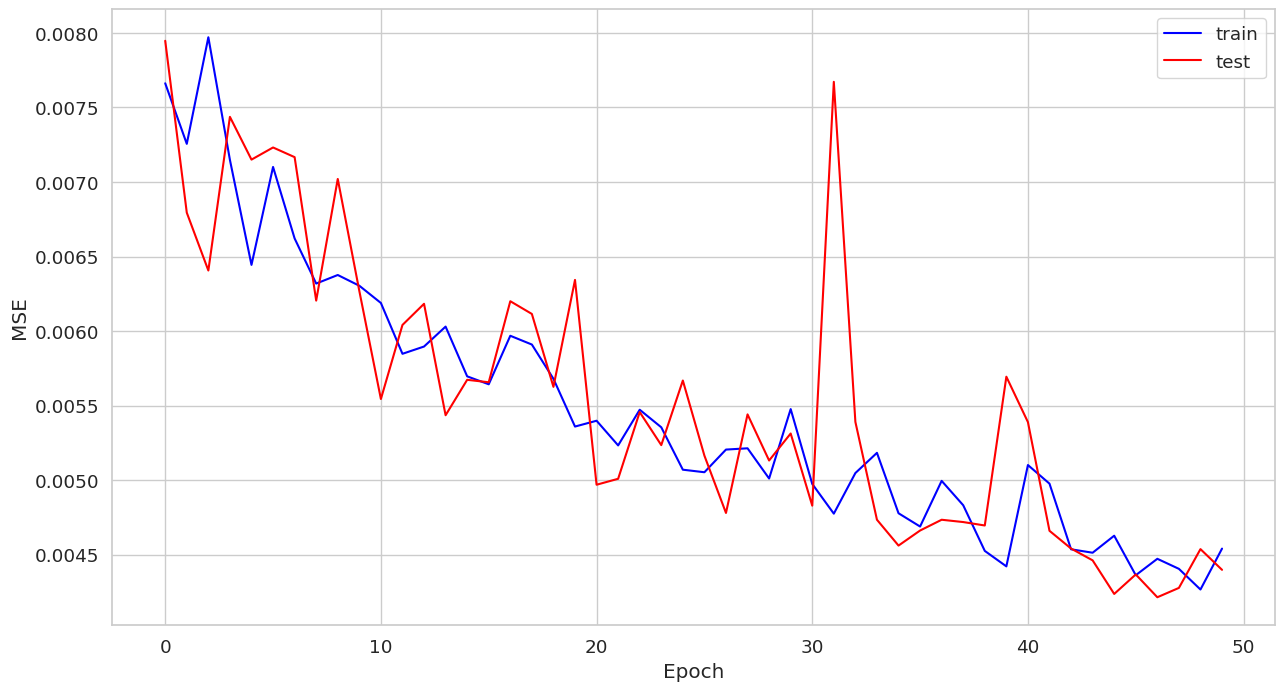

In [225]:
plt.figure(figsize=(15,8))
plt.plot(logs['train_loss'], c='blue', label='train')
plt.plot(logs['test_loss'], c='red', label='test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Добавим шум в целевую переменную для усложнения задачи

## Тестим на реальных данных MSFT

In [238]:
idx = 2
real_df = real_data_to_format(msft_calls[idx], msft_stock_price, maturities[idx], 0.05)

In [239]:
msft_calls[idx].head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,MSFT220401C00200000,2022-03-11 18:31:22+00:00,200.0,85.50,92.10,96.2,0.000000,0.000000,2.0,21,1.192387,True,REGULAR,USD
1,MSFT220401C00225000,2022-02-23 17:58:36+00:00,225.0,62.30,67.20,70.2,0.000000,0.000000,1.0,0,0.745120,True,REGULAR,USD
2,MSFT220401C00235000,2022-03-16 15:01:43+00:00,235.0,56.45,57.85,61.2,8.450001,17.604168,60.0,1,0.775393,True,REGULAR,USD
3,MSFT220401C00240000,2022-03-16 16:35:02+00:00,240.0,50.71,52.35,55.9,5.879997,13.116211,2.0,28,0.686282,True,REGULAR,USD
4,MSFT220401C00245000,2022-03-08 15:09:01+00:00,245.0,30.80,47.50,51.0,0.000000,0.000000,1.0,20,0.642826,True,REGULAR,USD


In [240]:
columns = [
    # 'log_time_value',
    'log_V2K',
    'r',
    'T',
    # 'log_S2K'
    'S2K'
]
target = 'sigma'
real_dataset = MyDataset(real_df, columns, target)
real_dataloader = DataLoader(real_dataset, shuffle=False, batch_size=len(real_dataset))

In [241]:
model.eval()
with torch.no_grad():
    X, y = next(iter(real_dataloader))
    X = X.to(device)
    y = y.unsqueeze(1)
    out = model(X).cpu()
    loss = criterion(out, y)
    print(f'Loss: {loss.item():0.4f}')

Loss: 0.0612


In [242]:
print(f'Train loss: {logs["train_loss"][-1]:0.4f}')
print(f'Test loss: {logs["test_loss"][-1]:0.4f}')

Train loss: 0.0045
Test loss: 0.0044


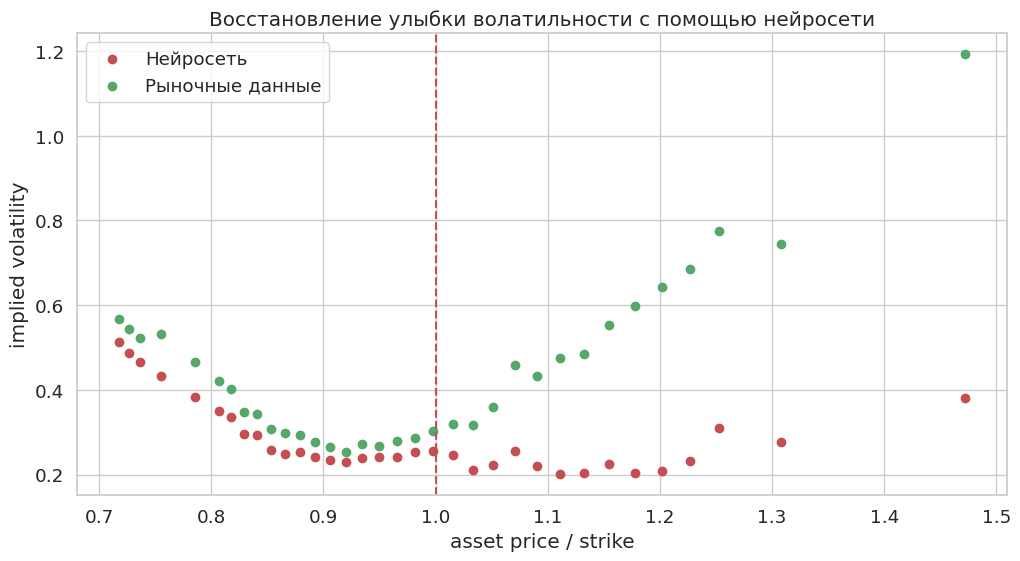

In [243]:
plt.figure(figsize=(12,6))
plt.title('Восстановление улыбки волатильности с помощью нейросети')
plt.scatter(y=out[:,0], x=real_df.S2K, c='r', label='Нейросеть')
plt.scatter(x=real_df.S2K, y=real_df.sigma, c='g', label='Рыночные данные')
plt.axvline(x=1, c='r', linestyle='--')
plt.xlabel('asset price / strike')
plt.ylabel('implied volatility')
plt.legend()
plt.show()

Надо расширить границы семплинга параметров, чтобы нейросеть могла обучиться более подробно   
Так же стоит добавить шум при обучении, чтобы сетка была более стабильна

In [1]:
2+2

4